In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import nbimporter
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
#for the millions format function
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tkr
import matplotlib as mpl
from datetime import datetime, timedelta
from pandas import DataFrame
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import re
import sqlite3

def thousand_count_y(y, pos):
    return '{:.0f} K'.format(y*1e-3)
formatter_thousand_count_y = FuncFormatter(thousand_count_y)
#ax2.yaxis.set_major_formatter(formatter_thousand_count_y)

def millons_count_y(y, pos):
    return '{:.0f} M'.format(y*1e-6)
formatter_millons_count_y = FuncFormatter(millons_count_y)
#ax2.yaxis.set_major_formatter(formatter_millons_count_y)

def thousand_count_x(x, pos):
    return '{:.0f} K'.format(x*1e-3)
formatter_thousand_count_x = FuncFormatter(thousand_count_x)
#ax2.yaxis.set_major_formatter(formatter_thousand_count_x)

def millons_count_x(x, pos):
    return '{:.0f} M'.format(x*1e-6)
formatter_millons_count_x = FuncFormatter(millons_count_x)
#ax2.yaxis.set_major_formatter(formatter_millons_count_x)

def thousand_real_y(y, pos):
    return 'R${:.0f} K'.format(y*1e-3)
formatter_thousand_real_y = FuncFormatter(thousand_real_y)
#ax2.yaxis.set_major_formatter(formatter_thousand_real_y)

def millons_real_y(y, pos):
    return 'R${:.1f} M'.format(y*1e-6)
formatter_millons_real_y = FuncFormatter(millons_real_y)
#ax2.yaxis.set_major_formatter(formatter_millons_real_y)

def thousand_real_x(x, pos):
    return 'R${:.0f} K'.format(x*1e-3)
formatter_thousand_real_x = FuncFormatter(thousand_real_x)
#ax2.yaxis.set_major_formatter(formatter_thousand_real_x)

def millons_real_x(x, pos):
    return 'R${:.1f} M'.format(x*1e-6)
formatter_millons_real_x = FuncFormatter(millons_real_x)
#ax2.yaxis.set_major_formatter(formatter_millons_real_x)


In [3]:
conn = sqlite3.connect('D:\\project\\dataset\\brazil_ecommerce.db')

#lấy dữ liệu thành các df
customers = pd.read_sql_query("SELECT * FROM customers", conn)
geolocation = pd.read_sql_query('select * from geolocation', conn)
order_items = pd.read_sql_query('select * from order_items', conn)
order_payments = pd.read_sql_query('select * from order_payments', conn)
order_reviews = pd.read_sql_query('select * from order_reviews', conn)
orders = pd.read_sql_query('select * from orders', conn)
products = pd.read_sql_query('select * from products', conn)
sellers = pd.read_sql_query('select * from sellers', conn)
products_category_translation = pd.read_sql_query('select * from product_category_name_translation', conn)
# Đóng kết nối
conn.close()


In [6]:
# Change data type for date columns in dataframe orders
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    orders[col] = pd.to_datetime(orders[col])

# Extracting attributes for purchase date - Year and Month
orders['order_purchase_year'] = orders['order_purchase_timestamp'].apply(lambda x: x.year)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.month)
orders['order_purchase_month_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders['order_purchase_year_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders['order_purchase_date'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
orders['order_purchase_day'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
orders['order_purchase_time_day'] = pd.cut(orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# Delete 2016 data
orders.drop(orders.loc[orders["order_purchase_year"]==2016].index, inplace=True)

In [7]:
customers.head()

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
#remove duplicate values
customers = customers.drop_duplicates(subset=["customer_unique_id"])
customers["customer_city"] = customers["customer_city"].str.capitalize()
customers.head()

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,Sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,Sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP


In [9]:
#The 10 cities with the most clients
clients_by_city = customers.groupby("customer_city").count()["customer_unique_id"].reset_index().sort_values(by="customer_unique_id",ascending=False).head(10)
clients_by_city.rename(columns = {"customer_unique_id":"total"}, inplace=True)
clients_by_city


,customer_city,total
3596,Sao paulo,14971
3154,Rio de janeiro,6611
453,Belo horizonte,2671
558,Brasilia,2066
1143,Curitiba,1462
707,Campinas,1397
2963,Porto alegre,1326
3246,Salvador,1208
1529,Guarulhos,1151
3427,Sao bernardo do campo,908


In [10]:
#The 10 states with the most clients
clients_by_state = customers.groupby(["customer_state"]).count()["customer_unique_id"].reset_index().sort_values(by="customer_unique_id",ascending=False).head(10)
clients_by_state.rename(columns = {"customer_unique_id":"total"}, inplace=True)
clients_by_state

,customer_state,total
25,SP,40295
18,RJ,12377
10,MG,11255
22,RS,5277
17,PR,4882
23,SC,3529
4,BA,3276
6,DF,2073
7,ES,1963
8,GO,1951


In [11]:
# merge elements of the data frame (customer, purchase date) to know the trend of how many customers made their first purchase
clients_x_date = pd.merge(customers, orders, on = "customer_id")
clients_x_date.head()


,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,May,201705,20170516,16,1,Tue,15,Afternoon
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,Sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,Jan,201801,20180112,12,4,Fri,20,Night
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,Sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,May,201805,20180519,19,5,Sat,16,Afternoon
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3,Mar,201803,20180313,13,1,Tue,16,Afternoon
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7,Jul,201807,20180729,29,6,Sun,9,Morning


In [12]:
sellers["seller_city"] = sellers["seller_city"].str.capitalize()
sellers.head()

,seller_id,geolocation_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,Campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,Mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,Rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,Sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,Braganca paulista,SP


In [13]:
#The 10 cities with the most sellers
sellers_by_city = sellers.groupby("seller_city").count()["seller_id"].reset_index().sort_values(by="seller_id",ascending=False).head(10)
sellers_by_city.rename(columns = {"seller_id":"total"}, inplace=True)
sellers_by_city.head()

,seller_city,total
517,Sao paulo,694
159,Curitiba,127
450,Rio de janeiro,96
64,Belo horizonte,68
442,Ribeirao preto,52


In [14]:
#The 10 states with the most sellers
sellers_by_states = sellers.groupby("seller_state").count()["seller_id"].reset_index().sort_values(by="seller_id",ascending=False).head(10)
sellers_by_states.rename(columns = {"seller_id":"total"}, inplace=True)
sellers_by_states.head()

,seller_state,total
22,SP,1849
15,PR,349
8,MG,244
20,SC,190
16,RJ,171


In [15]:
# merge elements of the data frame (customer, purchase date) to know the trend of how many customers made their first purchase
sellers_x_date = pd.merge(order_items,orders, on = "order_id")
sellers_x_date = sellers_x_date.drop_duplicates(subset=["seller_id"])
sellers_x_date.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017,9,Sep,201709,20170913,13,2,Wed,8,Morning
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017,4,Apr,201704,20170426,26,2,Wed,10,Morning
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018,1,Jan,201801,20180114,14,6,Sun,14,Afternoon
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018,8,Aug,201808,20180808,8,2,Wed,10,Morning
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017,2,Feb,201702,20170204,4,5,Sat,13,Afternoon


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4130302979.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4130302979.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4130302979.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4130302979.py:84: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same ef

Text(0.5, 0.98, 'Customers and Sellers (2017-2018)')

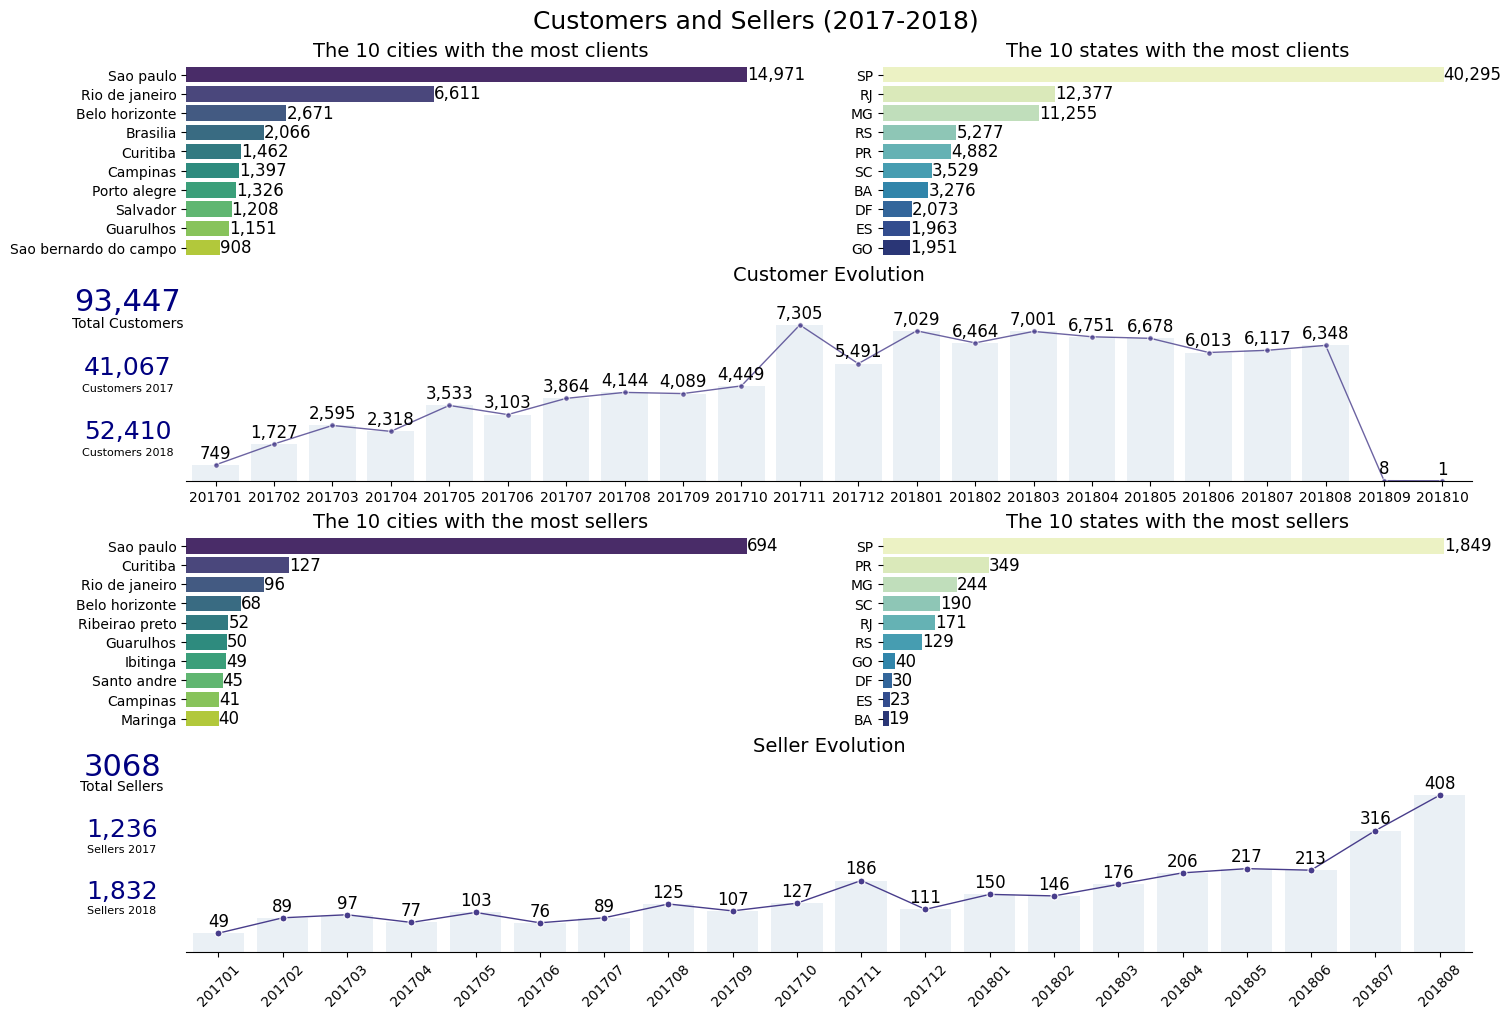

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(5, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
#ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
#ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[3, :])

#Customer city
sns.barplot(x="total", y="customer_city", data=clients_by_city, ax=ax1, palette='viridis')
ax1.set_title("The 10 cities with the most clients", size=14, color='black')
ax1.set_xlabel("")
ax1.set_ylabel("")
for rect in ax1.patches:
    ax1.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False) 

#Customer states
sns.barplot(x="total", y='customer_state', data=clients_by_state, ax=ax2, palette="YlGnBu")
ax2.set_title("The 10 states with the most clients", size=14, color='black')
ax2.set_xlabel("")
ax2.set_ylabel("")
for rect in ax2.patches:
    ax2.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

#Customer per year
sns.lineplot(x="order_purchase_year_month", y="order_id", data=clients_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax3, alpha=0.8,
             color='darkslateblue', linewidth=1, marker='o', markersize=4)
sns.barplot(x="order_purchase_year_month", y="order_id", data=clients_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax3, alpha=0.1)
ax3.set_title("Customer Evolution", size=14, color="black")
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_ylim(0,9000)
#plt.setp(ax3.get_xticklabels(), rotation=45)
for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="top", xytext=(0, 15), textcoords="offset points", 
                    color= "black", size=12)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.set_yticklabels([])
ax3.set_yticks([])

#Total de Customers
ax3.text(-1.5, 8000, "93,447", fontsize=22, ha='center', color="navy")
ax3.text(-1.5, 7200, "Total Customers", fontsize=10, ha='center')
ax3.text(-1.5, 5000, "41,067", fontsize=18, ha='center', color="navy")
ax3.text(-1.5, 4200, "Customers 2017", fontsize=8, ha='center')
ax3.text(-1.5, 2000, "52,410", fontsize=18, ha='center', color="navy")
ax3.text(-1.5, 1200, "Customers 2018", fontsize=8, ha='center')

# Sellers city
sns.barplot(x="total", y="seller_city", data=sellers_by_city, ax=ax5, palette='viridis')
ax5.set_title("The 10 cities with the most sellers", size=14, color='black')
ax5.set_xlabel("")
ax5.set_ylabel("")
for rect in ax5.patches:
    ax5.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.axes.get_xaxis().set_visible(False)

# Sellers states
sns.barplot(x="total", y="seller_state", data=sellers_by_states, ax=ax6, palette="YlGnBu")
ax6.set_title("The 10 states with the most sellers", size=14, color='black')
ax6.set_xlabel("")
ax6.set_ylabel("")
for rect in ax6.patches:
    ax6.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.axes.get_xaxis().set_visible(False)

#Sellers per year
sns.lineplot(x="order_purchase_year_month", y="order_id", data=sellers_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax8,
             color='darkslateblue', linewidth=1, marker='o', markersize=5)
sns.barplot(x="order_purchase_year_month", y="order_id", data=sellers_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax8, alpha=0.1)
ax8.set_title("Seller Evolution", size=14, color="black")
ax8.set_xlabel("")
ax8.set_ylabel("")
ax8.set_ylim(0, 500)
plt.setp(ax8.get_xticklabels(), rotation=45)
for p in ax8.patches:
        ax8.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="top", xytext=(0, 15), textcoords="offset points", 
                    color= "black", size=12)
ax8.spines["top"].set_visible(False)
ax8.spines["right"].set_visible(False)
ax8.spines["left"].set_visible(False)
ax8.set_yticklabels([])
ax8.set_yticks([])
        
#Total de Sellers
ax8.text(-1.5, 460, "3068", fontsize=22, ha='center', color="navy")
ax8.text(-1.5, 420, "Total Sellers", fontsize=10, ha='center')
ax8.text(-1.5, 300, "1,236", fontsize=18, ha='center', color="navy")
ax8.text(-1.5, 260, "Sellers 2017", fontsize=8, ha='center')
ax8.text(-1.5, 140, "1,832", fontsize=18, ha='center', color="navy")
ax8.text(-1.5, 100, "Sellers 2018", fontsize=8, ha='center')


plt.suptitle("Customers and Sellers (2017-2018)", size=18)

#plt.tight_layout()

C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\2716862673.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\2716862673.py:51: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




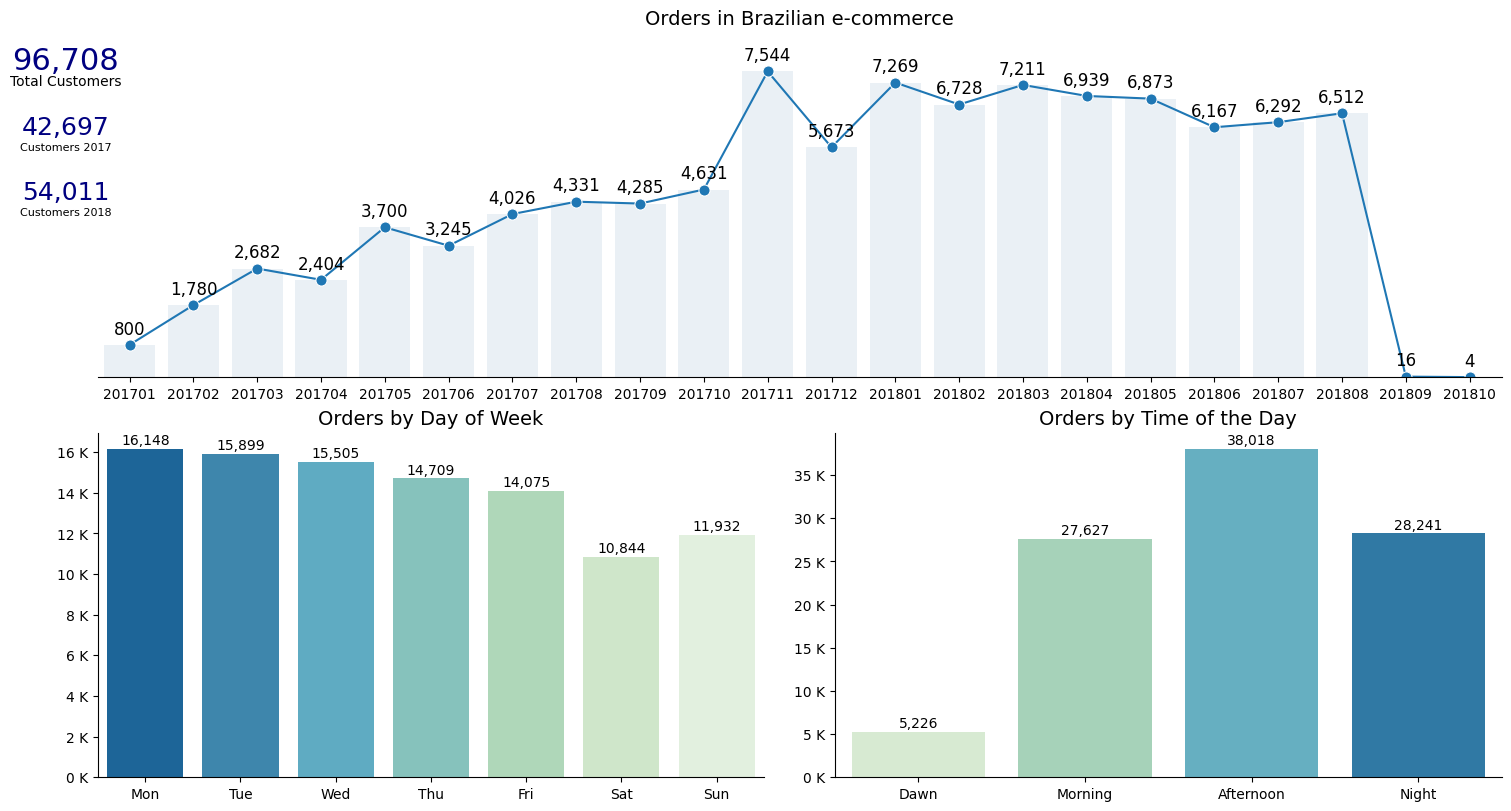

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(15, 8))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(x="order_purchase_year_month", y="order_id", data=orders.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(), ax=ax1, legend=False,
              marker='o',markersize=8)
sns.barplot(x="order_purchase_year_month", y="order_id", data=orders.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(), ax=ax1, alpha=0.1)
#plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Orders in Brazilian e-commerce", size=14, color='black')
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_ylim(0,8500)
for p in ax1.patches:
        ax1.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',
                    color= 'black', size=12)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_yticklabels([])
ax1.set_yticks([])

#Total Orders
ax1.text(-1, 7600, "96,708", fontsize=22, ha='center', color="navy")
ax1.text(-1, 7200, "Total Customers", fontsize=10, ha='center')
ax1.text(-1, 6000, "42,697", fontsize=18, ha='center', color="navy")
ax1.text(-1, 5600, "Customers 2017", fontsize=8, ha='center')
ax1.text(-1, 4400, "54,011", fontsize=18, ha='center', color="navy")
ax1.text(-1, 4000, "Customers 2018", fontsize=8, ha='center')

# Barchart - Total of orders by day of week
day_order= ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.countplot(x="order_purchase_dayofweek_name", data=orders, order=day_order, ax=ax2, palette="GnBu_r")
ax2.set_title("Orders by Day of Week", size=14, color='black')
ax2.set_xlabel("")
ax2.set_ylabel("")
for p in ax2.patches:
        ax2.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= "black")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_major_formatter(formatter_thousand_count_y)

# Barchart - Total of orders by time of the day
sns.countplot(x="order_purchase_time_day", data=orders,ax=ax3, palette="GnBu")
ax3.set_title("Orders by Time of the Day", size=14, color='black')
ax3.set_xlabel("")
ax3.set_ylabel("")
for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                     ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= "black")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_major_formatter(formatter_thousand_count_y)



#plt.tight_layout()
plt.show()

In [18]:
#We group order_id of items to get the total cost of the order. (this because the purchase breakdown comes)
price = order_items.groupby("order_id").agg({ 'price': 'sum', 'freight_value': 'sum'}).reset_index()
price["total"] = price["price"] + price["freight_value"]
price


#We join the prices of the dataframe with the dataframe of orders, to calculate the sales by year, month, etc.
sales = pd.merge(price, orders, on="order_id")
sales.head()

,order_id,price,freight_value,total,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017,9,Sep,201709,20170913,13,2,Wed,8,Morning
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017,4,Apr,201704,20170426,26,2,Wed,10,Morning
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018,1,Jan,201801,20180114,14,6,Sun,14,Afternoon
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018,8,Aug,201808,20180808,8,2,Wed,10,Morning
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017,2,Feb,201702,20170204,4,5,Sat,13,Afternoon


In [19]:
sales_year_month = sales.groupby(by=["order_purchase_year", "order_purchase_year_month","order_purchase_month_name"]).agg({"order_id": "count","price": "sum","freight_value": "sum","total": "sum"}).reset_index()
sales_year_month.head()

,order_purchase_year,order_purchase_year_month,order_purchase_month_name,order_id,price,freight_value,total
0,2017,201701,Jan,789,120312.87,16875.62,137188.49
1,2017,201702,Feb,1733,247303.02,38977.60,286280.62
2,2017,201703,Mar,2641,374344.30,57704.29,432048.59
3,2017,201704,Apr,2391,359927.23,52495.01,412422.24
4,2017,201705,May,3660,506071.14,80119.81,586190.95


In [20]:
#sales_year = sales.groupby(by=["order_purchase_year"]).agg({"order_id": "count","price": "sum","freight_value": "sum","total": "sum"}).reset_index()
sales_year = sales.groupby(by=["order_purchase_year"]).agg({"total": "sum"}).reset_index()
sales_year

,order_purchase_year,total
0,2017,7142672.43
1,2018,8643697.60


Text(0.5, 0.98, '')

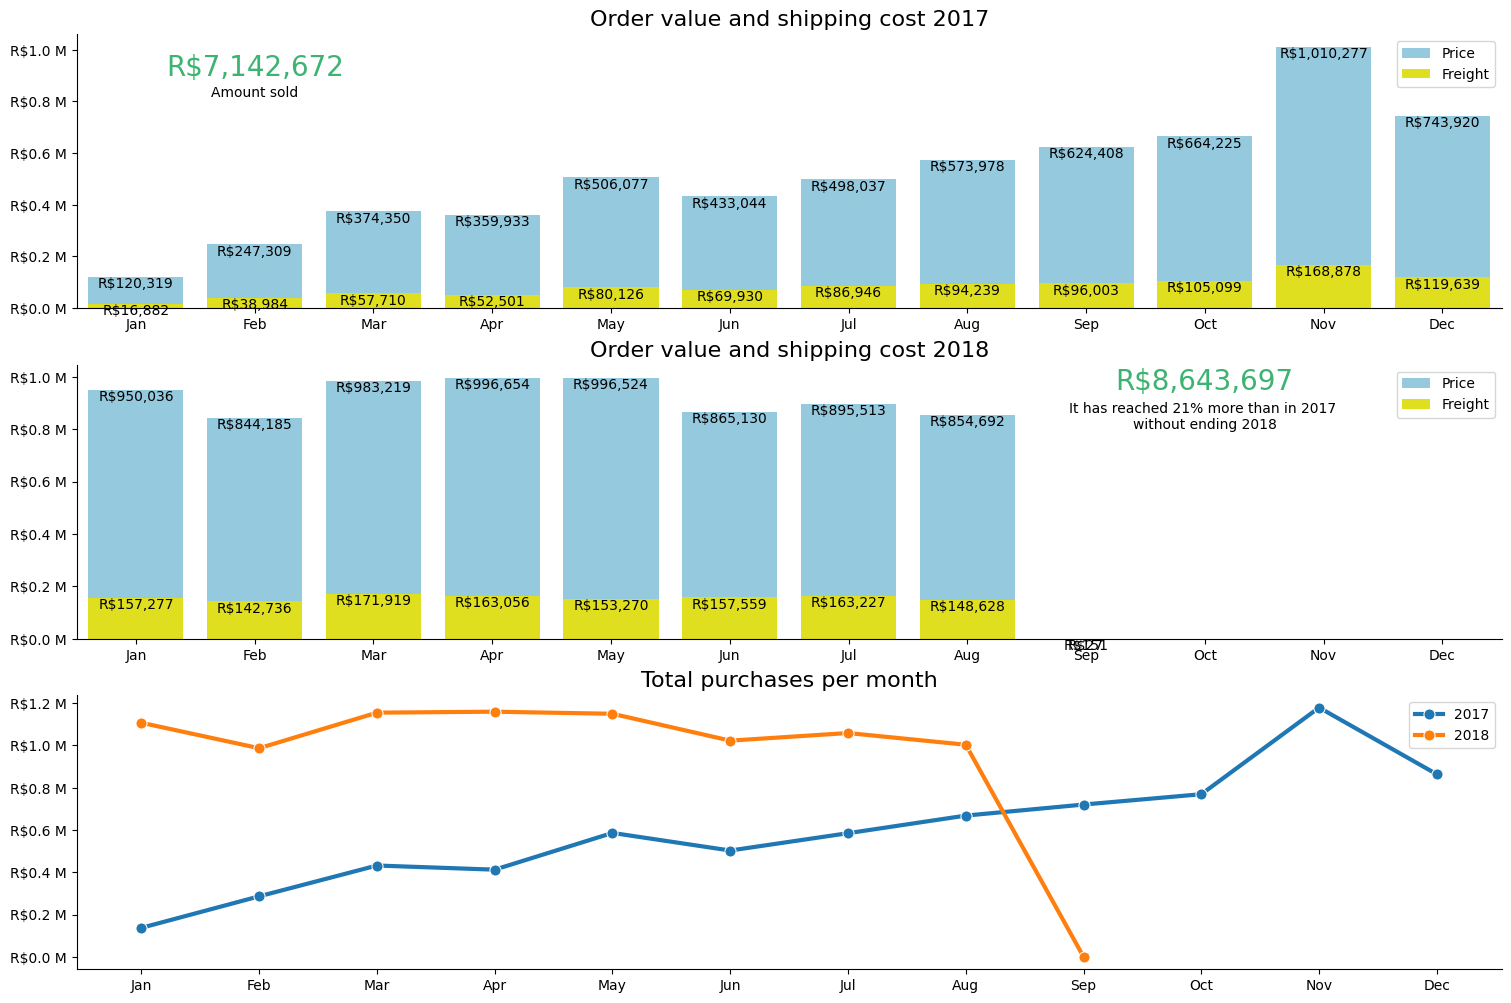

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2,:])



month_order= ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

sns.barplot(x="order_purchase_month_name", y="price", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], order=month_order, ax=ax1, color="skyblue", label="Price")
sns.barplot(x="order_purchase_month_name", y="freight_value", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], order=month_order, ax=ax1, color="yellow", label="Freight")

ax1.set_title("Order value and shipping cost 2017", size=16)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.legend(loc="upper right")
for p in ax1.patches:
        ax1.annotate('R${:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='top',
                    color= 'black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_major_formatter(formatter_millons_real_y)

ax1.text(1, 900000, f'R$7,142,672', fontsize=20, color='mediumseagreen', ha='center')
ax1.text(1, 820000, 'Amount sold', fontsize=10, ha='center')


sns.barplot(x="order_purchase_month_name", y="price", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], order=month_order, ax=ax2, color="skyblue", label="Price")
sns.barplot(x="order_purchase_month_name", y="freight_value", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], order=month_order, ax=ax2, color="yellow", label="Freight")
ax2.set_title("Order value and shipping cost 2018", size=16)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.legend(loc="upper right")
for p in ax2.patches:
        ax2.annotate('R${:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='top',
                    color= 'black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_major_formatter(formatter_millons_real_y)

ax2.text(9, 950000, f'R$8,643,697', fontsize=20, color='mediumseagreen', ha='center')
ax2.text(9, 800000, 'It has reached 21% more than in 2017 \nwithout ending 2018', fontsize=10, ha='center')

sns.lineplot(x="order_purchase_month_name", y='total', data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], ax=ax3,linewidth=3.0, label="2017", marker='o', markersize=8)
sns.lineplot(x="order_purchase_month_name", y='total', data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], ax=ax3,linewidth=3.0,label="2018", marker='o', markersize=8)
ax3.set_title("Total purchases per month", size=16, color='black')
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_major_formatter(formatter_millons_real_y)

plt.suptitle("")

In [22]:
# merge elements of the data frame (order_payments, orders) to know the trend of the payment method of the customers
pay = pd.merge(order_payments, orders, on="order_id")
pay["payment_type"] = pay["payment_type"].str.capitalize()
#Grouping for pie chart, what is the most used payment method?
pay1 = pay.groupby(by=["payment_type"]).agg({"order_id": "count","payment_value": "sum"}).reset_index().sort_values(by="order_id",ascending=False)
#pay1["%"] = pay1["order_id"] / pay1["order_id"].sum() * 100
#pay1=round(pay1,0)
pay1

,payment_type,order_id,payment_value
1,Credit_card,76537,12493521.71
0,Boleto,19721,2859682.21
4,Voucher,5752,378557.80
2,Debit_card,1527,217748.06
3,Not_defined,3,0.00


In [23]:
#Group for bar chart to count transactions by payment type.
pay2 = pay.groupby(by=["payment_type", "order_purchase_year"]).agg({"order_id": "count"}).reset_index().sort_values(by=["order_purchase_year","order_id"],ascending=False)
pay2.head()

,payment_type,order_purchase_year,order_id
3,Credit_card,2018,41969
1,Boleto,2018,10213
8,Voucher,2018,2725
5,Debit_card,2018,1105
6,Not_defined,2018,3


In [24]:
#Group to know which are the trends of the payment methods
#pay.groupby(by=["order_purchase_year", "order_purchase_year_month","order_purchase_month_name"]).agg({"order_id": "count","price": "sum","freight_value": "sum","total": "sum"}).reset_index()
pay3 = pay.groupby(by=["order_purchase_year_month", "payment_type"]).agg({"order_id": "count"}).reset_index().sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
pay3.head()

,order_purchase_year_month,payment_type,order_id
1,201701,Credit_card,583
0,201701,Boleto,197
3,201701,Voucher,61
2,201701,Debit_card,9
5,201702,Credit_card,1356


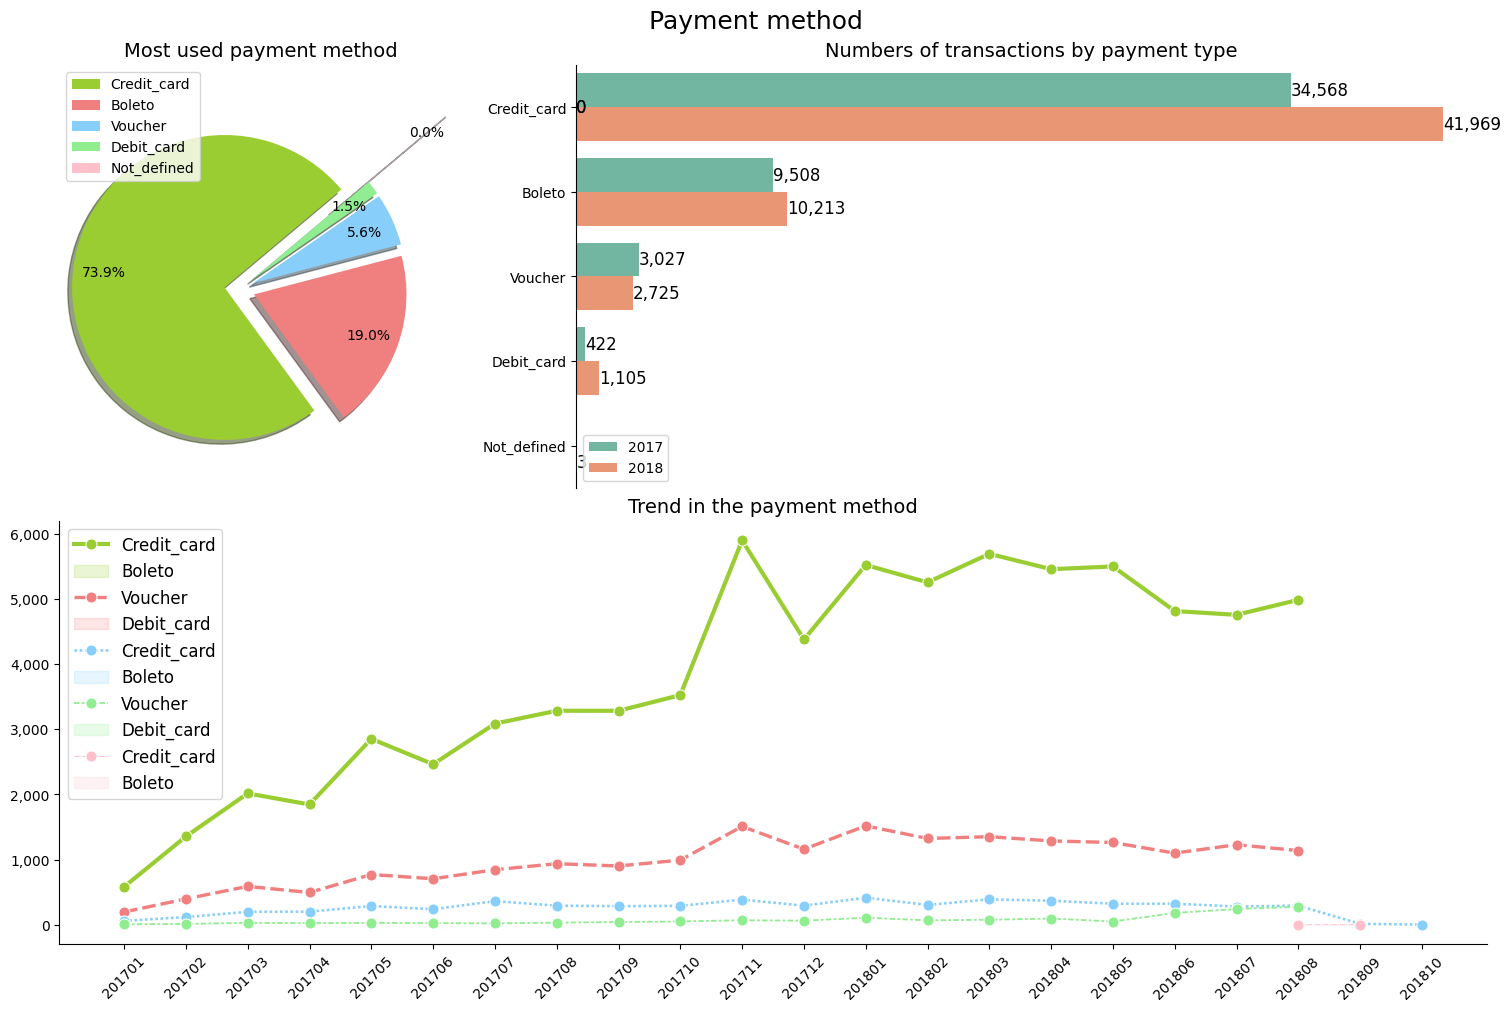

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
#ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1,:])

colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode = (0.1, 0.1, 0.1, 0.1, 0.8)

ax1.pie(pay1["order_id"], explode=explode, autopct='%1.1f%%',shadow=True, startangle=40,pctdistance=0.8, colors=colors_list)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=pay1["payment_type"], loc='best')
ax1.set_title("Most used payment method", size=14, color='black')

sns.barplot(x="order_id", y="payment_type", data=pay2,  ax=ax2, hue="order_purchase_year", palette="Set2")
ax2.legend(loc="best")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("Numbers of transactions by payment type", size=14, color="black" )
for rect in ax2.patches:
    ax2.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False) 
#ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
sns.lineplot(x='order_purchase_year_month', y='order_id', data=pay3, ax=ax4, hue='payment_type',legend=False,
             style='payment_type', size='payment_type', palette=colors_list, marker='o',markersize=8)
ax4.legend(labels=pay3["payment_type"], loc='upper left',fontsize=12)
ax4.set_title("Trend in the payment method", size=14, color="black")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.setp(ax4.get_xticklabels(), rotation=45)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.suptitle("Payment method", size=18)

plt.show()


In [26]:
#merge data frame elements (products, product category) to know the English name of the products
products = pd.merge(products, products_category_translation, on="product_category_name")
#products

#Assemble a new dataframe with only product_id and the English name of the product
products = products[["product_id", "product_category_name_english"]]
#products.head()

#We put the product category in the items file
products = pd.merge(order_items, products, on="product_id")
#products

#We calculate the total that the customer paid for the product
products["total"] = products["price"] + products["freight_value"]
#new dataframe with the columns we just need
products = products[["order_id", "product_id", "price" , "freight_value", "total", "product_category_name_english"]]
#products

#We join our dataframe products with orders to obtain the information of the dates
products = pd.merge(products, orders, on="order_id")
#products

#new dataframe with the columns we just need
products = products[["product_id", "price" , "freight_value", "total", "product_category_name_english","order_purchase_year","order_purchase_month_name","order_purchase_year_month"]]
products["product_category_name_english"] = products["product_category_name_english"].str.capitalize()
products.head()


,product_id,price,freight_value,total,product_category_name_english,order_purchase_year,order_purchase_month_name,order_purchase_year_month
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,72.19,Cool_stuff,2017,Sep,201709
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,73.86,Cool_stuff,2017,Jun,201706
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,83.23,Cool_stuff,2018,May,201805
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,75.07,Cool_stuff,2017,Aug,201708
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,72.19,Cool_stuff,2017,Aug,201708


In [27]:
#We group by category to generate the scatter plot
products_category = products.groupby("product_category_name_english").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(20)
products_category.head()


,product_category_name_english,order_purchase_year_month,total
7,Bed_bath_table,11107,1241075.14
43,Health_beauty,9619,1435611.23
65,Sports_leisure,8622,1152729.37
39,Furniture_decor,8265,895323.28
15,Computers_accessories,7806,1057532.31


In [28]:
#We group by category to generate the bar plot
products_category_year = products.groupby(by=["product_category_name_english","order_purchase_year"]).agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year","order_purchase_year_month"], ascending=[True,False])
products_category_year.head()

,product_category_name_english,order_purchase_year,order_purchase_year_month,total
14,Bed_bath_table,2017,5223,590280.44
78,Furniture_decor,2017,4147,418857.15
129,Sports_leisure,2017,4095,530730.03
86,Health_beauty,2017,3668,550420.11
30,Computers_accessories,2017,3098,462761.27


In [29]:
products_cat_trends = products.groupby(by=["product_category_name_english","order_purchase_year_month"]).agg({"order_purchase_year" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year_month","order_purchase_year","product_category_name_english"], ascending=[True,False,True])
#We remove the data from 2016, we are only analyzing 2017 and 2018
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201609"].index, inplace=True)
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201610"].index, inplace=True)
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201612"].index, inplace=True)

#We filter the categories that are in the Top 5 by category in 2017 y 2018
products_cat_trends = products_cat_trends[(products_cat_trends["product_category_name_english"]=="Bed_bath_table") | 
                                  (products_cat_trends["product_category_name_english"]=="Furniture_decor")|
                                  (products_cat_trends["product_category_name_english"]=="Sports_leisure")|
                                  (products_cat_trends["product_category_name_english"]=="Health_beauty")|
                                  (products_cat_trends["product_category_name_english"]=="Computers_accessories")]
products_cat_trends.head()

,product_category_name_english,order_purchase_year_month,order_purchase_year,total
654,Furniture_decor,201701,182,16461.75
725,Health_beauty,201701,85,14039.74
1101,Sports_leisure,201701,80,11447.27
122,Bed_bath_table,201701,48,4817.27
246,Computers_accessories,201701,31,4377.60


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4057258984.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\4057258984.py:56: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




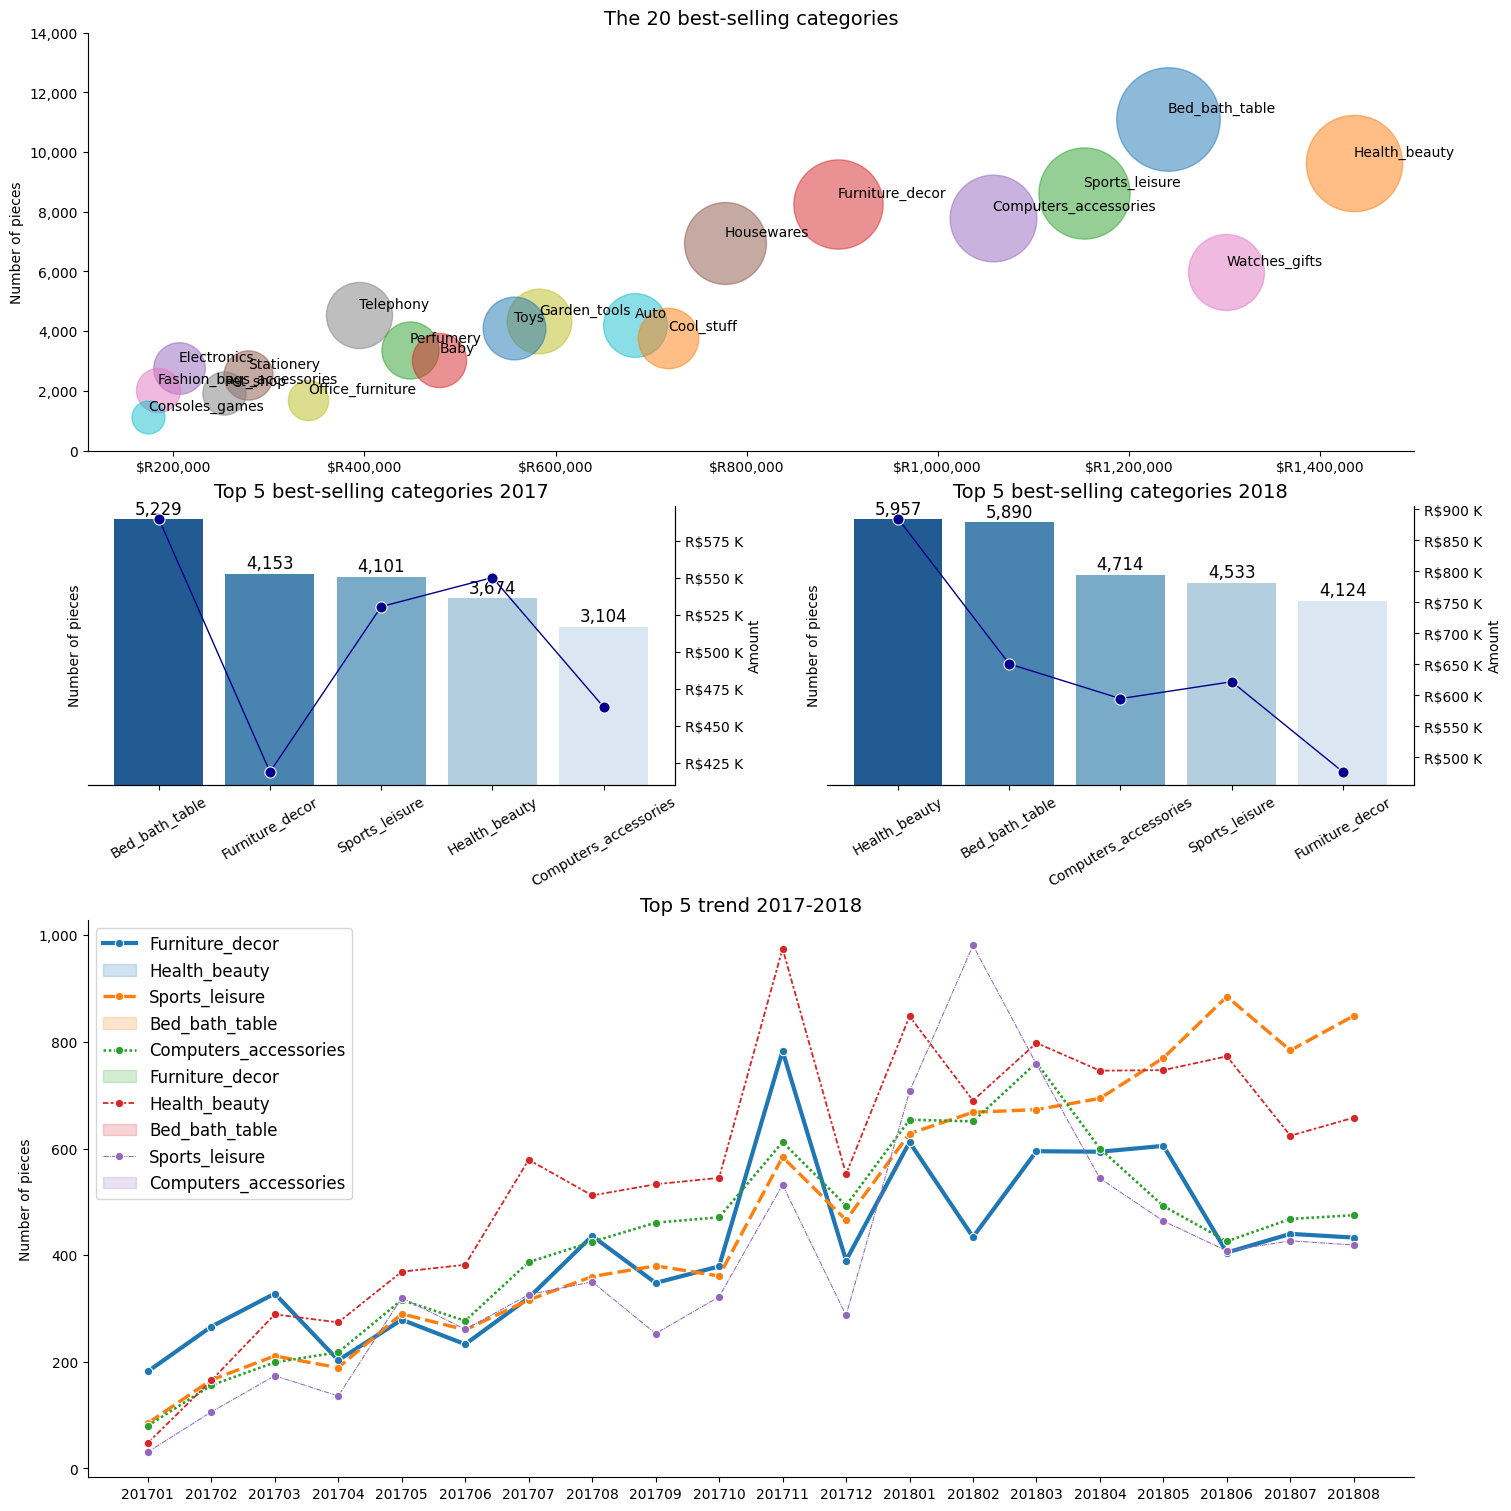

In [30]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))

# Axis definition
gs = GridSpec(9, 2, figure=fig)
ax1 = fig.add_subplot(gs[:3,0:])
ax2 = fig.add_subplot(gs[3:5, 0])
ax3 = fig.add_subplot(gs[3:5, 1])
ax4 = fig.add_subplot(gs[5:,0:])

for product in products_category["product_category_name_english"].unique():
    data = products_category[products_category["product_category_name_english"] == product]
    ax1.scatter(data['total'],data['order_purchase_year_month'],
                s=0.5*data['order_purchase_year_month']**1,
                alpha = 0.5,
                label=product)
    
for index, row in products_category.iterrows():
    ax1.annotate(row['product_category_name_english'],
                 (row['total'], row['order_purchase_year_month']),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='left')

ax1.set_xlabel("")
ax1.set_ylabel("Number of pieces")
ax1.set_title("The 20 best-selling categories",size=14)
ax1.set_ylim(0,14000)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('$R{x:,.0f}'))
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

sns.barplot(x="product_category_name_english", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2017].head(5), ax=ax2, palette="Blues_r")
ax2.set_xlabel("")
ax2.set_ylabel("Number of pieces")
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_title("Top 5 best-selling categories 2017", size=14)
#ax2.set_ylim(0,6000)
plt.setp(ax2.get_xticklabels(), rotation=30)
for p in ax2.patches:
        ax2.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
#ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2_twx = ax2.twinx()
sns.lineplot(x="product_category_name_english", y='total', data=products_category_year.loc[products_category_year["order_purchase_year"]==2017].head(5), ax=ax2_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
#ax2_twx.set_ylim(0,990000)
ax2_twx.set_ylabel("Amount")
ax2_twx.spines['top'].set_visible(False)
ax2_twx.spines['left'].set_visible(False)
ax2_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

sns.barplot(x="product_category_name_english", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2018].head(5), ax=ax3, palette="Blues_r")
ax3.set_xlabel("")
ax3.set_ylabel("Number of pieces")
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title("Top 5 best-selling categories 2018", size=14)
for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
plt.setp(ax3.get_xticklabels(), rotation=30)
ax3_twx = ax3.twinx()
sns.lineplot(x="product_category_name_english", y='total', data=products_category_year.loc[products_category_year["order_purchase_year"]==2018].head(5), ax=ax3_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
#ax3_twx.set_ylim(0,990000)
ax3_twx.set_ylabel("Amount")
ax3_twx.yaxis.set_major_formatter(formatter_thousand_real_y)
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['left'].set_visible(False)

sns.lineplot(x='order_purchase_year_month', y='order_purchase_year', data=products_cat_trends, ax=ax4, hue='product_category_name_english',legend=False, style='product_category_name_english', size='product_category_name_english', marker='o', linewidth=3)
ax4.legend(labels=products_cat_trends["product_category_name_english"], loc='upper left', fontsize=12)
ax4.set_title("Top 5 trend 2017-2018", size=14)
ax4.set_ylabel("Number of pieces")
ax4.set_xlabel("")
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)



In [31]:
#We group by product to generate the scatter plot
products_top = products.groupby(by=["product_id","product_category_name_english"]).agg({"order_purchase_month_name" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_month_name", ascending=False).head(10)
products_top.head()

,product_id,product_category_name_english,order_purchase_month_name,total
21613,aca2eb7d00ea1a7b8ebd4e68314663af,Furniture_decor,527,44820.76
19296,99a4788cb24856965c36a24e339b6058,Bed_bath_table,488,51071.60
8414,422879e10f46682990de24d770e7f83d,Garden_tools,484,34201.26
7197,389d119b48cf3043d311335e499d9c6b,Garden_tools,392,28682.68
6917,368c6c730842d78016ad823897a372db,Garden_tools,388,27984.40


In [32]:
#We group by product to generate the bar plot
products_top_year = products.groupby(by=["product_id","order_purchase_year"]).agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year","order_purchase_year_month"], ascending=[True,False])
#We remove the data from 2016, we are only analyzing 2017 and 2018
products_top_year.drop(products_top_year.loc[products_top_year["order_purchase_year"]==2016].index, inplace=True)
products_top_year.head()

,product_id,order_purchase_year,order_purchase_year_month,total
22221,99a4788cb24856965c36a24e339b6058,2017,359,37819.85
9675,422879e10f46682990de24d770e7f83d,2017,276,20412.97
3128,154e7e31ebfa092203795c972e5804a6,2017,225,8021.22
8259,389d119b48cf3043d311335e499d9c6b,2017,219,16226.68
12205,53759a2ecddad2bb87a079a1f1519f73,2017,218,16239.55


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\3582843236.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\3582843236.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\3582843236.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL\AppData\Local\Temp\ipykernel_25400\3582843236.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same ef

Text(0.5, 0.98, 'Number of Pieces and Amount Sold \nby Products')

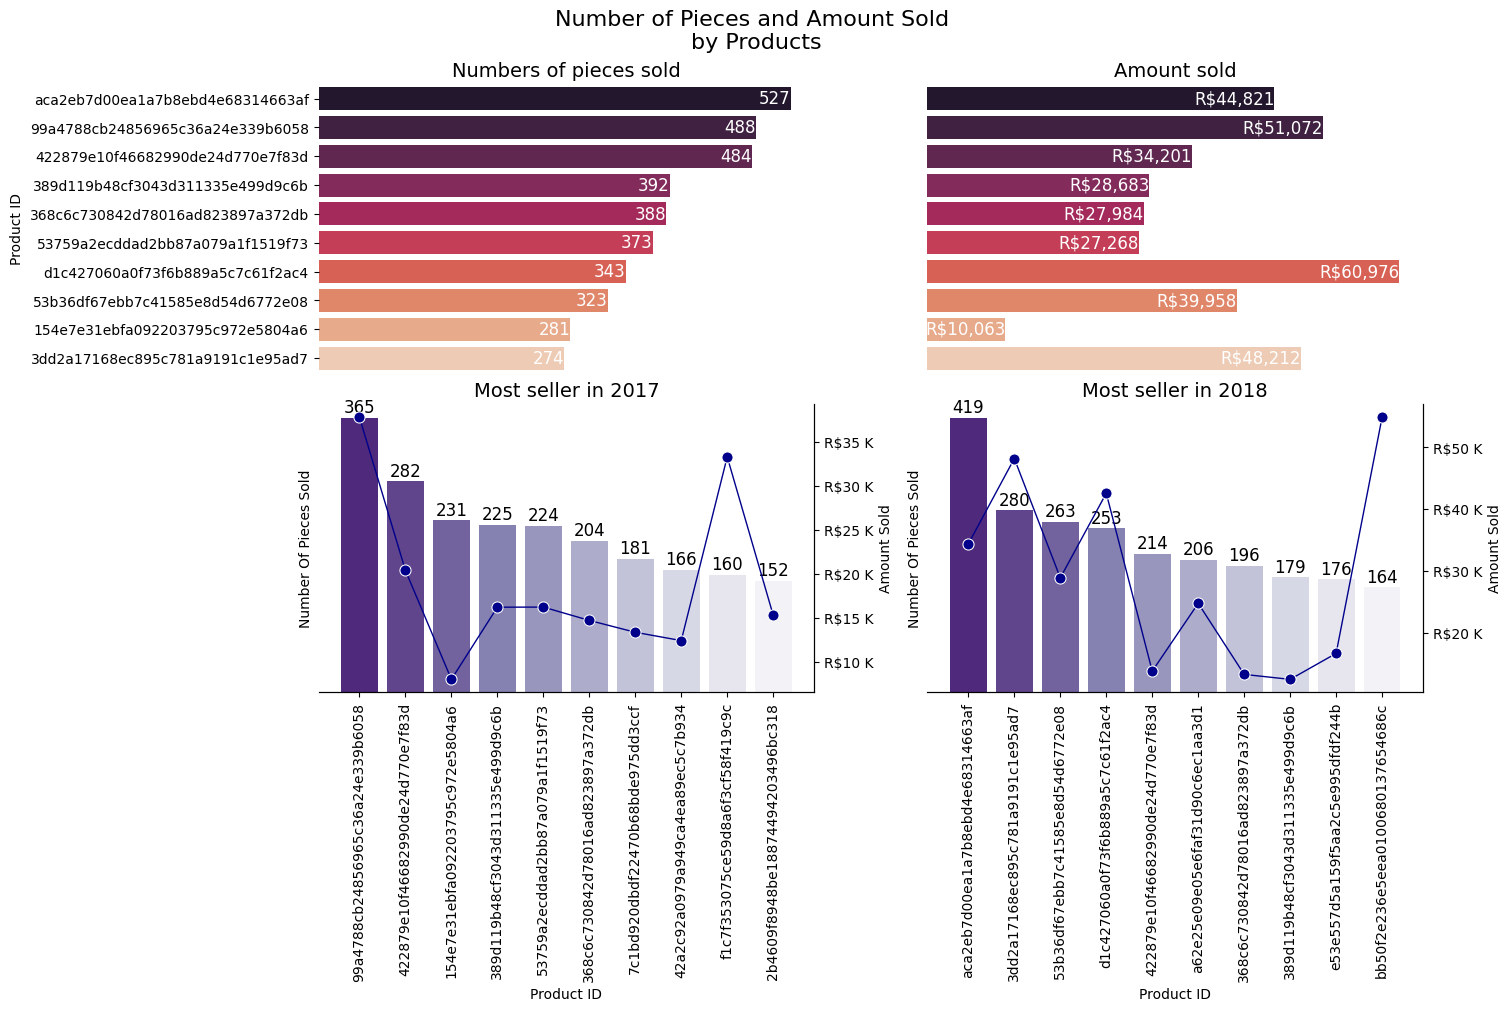

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2:,0])
ax4 = fig.add_subplot(gs[2:,1])

sns.barplot(x="order_purchase_month_name", y="product_id",  data=products_top, ax=ax1, palette="rocket")
ax1.set_xlabel("")
ax1.set_ylabel("Product ID")
ax1.set_title("Numbers of pieces sold",size=14)
for rect in ax1.patches:
    ax1.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='right', size=12, color="white")    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
    
sns.barplot(x="total", y="product_id",  data=products_top, ax=ax2, palette="rocket")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("Amount sold", size=14)
for rect in ax2.patches:
    ax2.annotate('R${:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='right', size=12, color="white")    
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

sns.barplot(x="product_id", y="order_purchase_year_month", data=products_top_year.loc[products_top_year["order_purchase_year"]==2017].head(10), ax=ax3, palette="Purples_r")
ax3.set_xlabel("Product ID")
ax3.set_ylabel("Number Of Pieces Sold")
plt.setp(ax3.get_xticklabels(), rotation=90)
ax3.set_title("Most seller in 2017", size=14)
ax3.set_yticklabels([])
ax3.set_yticks([])
for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3_twx = ax3.twinx()
sns.lineplot(x="product_id", y='total', data=products_top_year.loc[products_top_year["order_purchase_year"]==2017].head(10), ax=ax3_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
ax3_twx.set_ylabel("Amount Sold")
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['left'].set_visible(False)
ax3_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

sns.barplot(x="product_id", y="order_purchase_year_month", data=products_top_year.loc[products_top_year["order_purchase_year"]==2018].head(10), ax=ax4, palette="Purples_r")
ax4.set_xlabel("Product ID")
ax4.set_ylabel("Number Of Pieces Sold")
plt.setp(ax4.get_xticklabels(), rotation=90)
ax4.set_title("Most seller in 2018", size=14)
ax4.set_yticklabels([])
ax4.set_yticks([])
for p in ax4.patches:
        ax4.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4_twx = ax4.twinx()
sns.lineplot(x="product_id", y='total', data=products_top_year.loc[products_top_year["order_purchase_year"]==2018].head(10), ax=ax4_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
ax4_twx.set_ylabel("Amount Sold")
ax4_twx.spines['top'].set_visible(False)
ax4_twx.spines['left'].set_visible(False)
ax4_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

plt.suptitle("Number of Pieces and Amount Sold \nby Products", size=16)

In [34]:
order_status = orders.groupby("order_status").size().reset_index().sort_values(by=0,ascending=False)
order_status["order_status"] = order_status["order_status"].str.capitalize()
order_status

,order_status,0
3,Delivered,96211
6,Shipped,1098
7,Unavailable,602
1,Canceled,599
5,Processing,299
4,Invoiced,296
2,Created,5
0,Approved,2


In [35]:
fig = make_subplots(rows=1, cols=1, 
                    specs=[[{"type": "pie"}]],
                    vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=(""))

fig.add_trace(go.Pie(values= order_status[0], labels=order_status["order_status"], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                    hoverinfo='label+value', textinfo='label + value'), 
                    row=1, col=1)

fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_layout(height=400, bargap=0.4,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Orders Status (2016-2018)",
                  template="plotly_white",
                  title_font=dict(size=22, color='black', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.update_traces(rotation=90)
fig.update_traces(textposition="auto", selector=dict(type='pie'))

In [36]:
#We group the orders to know the seller
freight_value = order_items.groupby(by=["order_id", "seller_id"]).agg({"price" : "count","freight_value" : "sum"}).reset_index().sort_values(by="price", ascending=False)
#freight_value
# We group the freight value and the sales to know the dates made to the freight
freight_value = pd.merge(freight_value, sales, on = "order_id")
#freight_value
# We group the freight value and the sellers to know the city and state of the seller
freight_value = pd.merge(freight_value, sellers, on = "seller_id")
#freight_value
# We select the columns necessary for the analysis
freight_value = freight_value[["seller_id", "order_purchase_year", "order_purchase_year_month","order_purchase_timestamp", "order_delivered_carrier_date" , "order_delivered_customer_date", "order_estimated_delivery_date", "freight_value_x", "seller_city", "seller_state"]]
freight_value.head()

,seller_id,order_purchase_year,order_purchase_year_month,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,freight_value_x,seller_city,seller_state
0,2709af9587499e95e803a6498a5a56e9,2017,201707,2017-07-16 18:19:25,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,164.37,Sao paulo,SP
1,2709af9587499e95e803a6498a5a56e9,2018,201807,2018-07-25 09:57:52,2018-07-25 11:19:00,2018-08-02 11:28:39,2018-08-15,44.48,Sao paulo,SP
2,2709af9587499e95e803a6498a5a56e9,2017,201706,2017-06-13 22:33:24,2017-06-16 15:21:51,2017-07-03 15:45:56,2017-07-18,43.10,Sao paulo,SP
3,2709af9587499e95e803a6498a5a56e9,2017,201704,2017-04-22 11:35:35,2017-04-25 13:45:05,None,2017-05-23,29.73,Sao paulo,SP
4,2709af9587499e95e803a6498a5a56e9,2017,201709,2017-09-01 10:26:06,2017-09-01 19:12:29,2017-09-08 19:07:34,2017-09-21,11.85,Sao paulo,SP


In [37]:
# We check if there are rows that do not contain data
freight_value.isnull().sum()

seller_id                           0
order_purchase_year                 0
order_purchase_year_month           0
order_purchase_timestamp            0
order_delivered_carrier_date      977
order_delivered_customer_date    2152
order_estimated_delivery_date       0
freight_value_x                     0
seller_city                         0
seller_state                        0
dtype: int64

In [38]:
# We eliminate the rows that do not contain data in the columns "order delivered carrier date" and "order delivered customer date"
freight_value = freight_value.dropna(subset=["order_delivered_customer_date","order_delivered_carrier_date"])
#freight_value.head()

#Convert column order_delivered_customer_date (object) to datetime
freight_value["order_delivered_customer_date"] = freight_value["order_delivered_customer_date"].apply(pd.to_datetime)

# Formatting dates to calculate delivery time
freight_value["order_purchase_timestamp"] = pd.to_datetime(freight_value["order_purchase_timestamp"].dt.strftime("%Y-%m-%d"))
freight_value["order_delivered_carrier_date"] = pd.to_datetime(freight_value["order_delivered_carrier_date"].dt.strftime("%Y-%m-%d"))
freight_value["order_delivered_customer_date"] = pd.to_datetime(freight_value["order_delivered_customer_date"].dt.strftime("%Y-%m-%d"))

# We take the difference of days between the columns
freight_value["time_delivery_customer"] = freight_value["order_delivered_customer_date"] - freight_value["order_purchase_timestamp"]
freight_value["time_delivery_estimated"] = freight_value["order_delivered_customer_date"] - freight_value["order_estimated_delivery_date"]
freight_value["time_purchase_estimated_day_time"] = freight_value["order_estimated_delivery_date"] - freight_value["order_purchase_timestamp"]

#freight_value

# We convert the two columns into str
freight_value["time_delivery_customer"] = freight_value["time_delivery_customer"].astype(str)
freight_value["time_delivery_estimated"] = freight_value["time_delivery_estimated"].astype(str)
freight_value["time_purchase_estimated_day_time"] = freight_value["time_purchase_estimated_day_time"].astype(str)

separator_c = freight_value["time_delivery_customer"].str.rsplit(" ", n=1, expand=True)
separator_c.columns = ["customer_day_time", "1"]
separator_c = separator_c.drop(columns = ["1"])
freight_value = pd.concat([freight_value, separator_c], axis=1)

separator_d = freight_value["time_delivery_estimated"].str.rsplit(" ", n=1, expand=True)
separator_d.columns = ["delivery_day_time", "2"]
separator_d = separator_d.drop(columns = ["2"])
freight_value = pd.concat([freight_value, separator_d], axis=1)

separator_pe = freight_value["time_purchase_estimated_day_time"].str.rsplit(" ", n=1, expand=True)
separator_pe.columns = ["purchase_estimated_day_time", "2"]
separator_pe = separator_pe.drop(columns = ["2"])
freight_value = pd.concat([freight_value, separator_pe], axis=1)

freight_value["customer_day_time"] = freight_value["customer_day_time"].astype(int)
freight_value["delivery_day_time"] = freight_value["delivery_day_time"].astype(int)
freight_value["purchase_estimated_day_time"] = freight_value["purchase_estimated_day_time"].astype(int)

In [39]:
conditionlist = [
    (freight_value["delivery_day_time"] <=0),(freight_value["delivery_day_time"] > 0)]

choicelist = ["On Time", "Out of Time"]
freight_value['delivery_status'] = np.select(conditionlist, choicelist, default='Not Specified')

In [40]:
delivery_status = freight_value.groupby("delivery_status").count()["seller_id"].reset_index()
delivery_status

,delivery_status,seller_id
0,On Time,90997
1,Out of Time,6544


In [41]:
delivery_status_year = freight_value.groupby(by=["order_purchase_year","delivery_status"]).count()["seller_id"].reset_index()
delivery_status_year

,order_purchase_year,delivery_status,seller_id
0,2017,On Time,41465
1,2017,Out of Time,2459
2,2018,On Time,49532
3,2018,Out of Time,4085


In [44]:
#The 5 states that take the most time compared to the estimated date
# Convert 'delivery_day_time' to numeric
freight_value["delivery_day_time"] = pd.to_numeric(freight_value["delivery_day_time"], errors='coerce')

# Filter rows where 'delivery_day_time' is greater than or equal to 1
delivery_low = freight_value[freight_value["delivery_day_time"] >= 1].copy()

# Convert 'delivery_day_time' to numeric again (if needed)
delivery_low["delivery_day_time"] = pd.to_numeric(delivery_low["delivery_day_time"], errors='coerce')

# Group by 'seller_state' and calculate mean 'delivery_day_time', then sort and select top 10
delivery_low = delivery_low.groupby("seller_state")["delivery_day_time"].mean().reset_index().sort_values(by="delivery_day_time", ascending=False).head(10)

# Output the result
delivery_low

,seller_state,delivery_day_time
0,AM,38.000000
2,CE,26.500000
1,BA,14.888889
7,MG,13.649596
5,GO,13.307692
16,SC,12.605714
15,RS,12.442623
12,PR,12.310777
13,RJ,10.860465
4,ES,10.526316


In [45]:
#The 5 states that take less time to deliver compared to the estimated date
# Convert 'delivery_day_time' to numeric
freight_value["delivery_day_time"] = pd.to_numeric(freight_value["delivery_day_time"], errors='coerce')

# Filter rows where 'delivery_day_time' is less than or equal to 0
delivery_fast = freight_value[freight_value["delivery_day_time"] <= 0].copy()

# Convert 'delivery_day_time' to numeric again (if needed)
delivery_fast["delivery_day_time"] = pd.to_numeric(delivery_fast["delivery_day_time"], errors='coerce')

# Group by 'seller_state' and calculate mean 'delivery_day_time', then sort and select top 10
delivery_fast = delivery_fast.groupby("seller_state")["delivery_day_time"].mean().reset_index().sort_values(by="delivery_day_time", ascending=True).head(10)

# Output the result
delivery_fast

,seller_state,delivery_day_time
17,RO,-24.500000
11,PB,-19.794118
20,SE,-17.555556
8,MS,-17.372093
18,RS,-17.081224
12,PE,-16.685567
9,MT,-16.595420
2,CE,-16.320988
6,MA,-15.917460
14,PR,-15.566976


In [46]:
delivery = freight_value.groupby("seller_state").agg({"freight_value_x":"mean", "customer_day_time":"mean", "purchase_estimated_day_time": "mean"}).reset_index().sort_values(by="freight_value_x", ascending=False)
delivery.head()

,seller_state,freight_value_x,customer_day_time,purchase_estimated_day_time
17,RO,50.912857,17.428571,41.928571
2,CE,48.347241,17.655172,31.022989
11,PB,41.398000,12.571429,31.742857
4,ES,38.477573,13.003236,26.032362
13,PI,37.140909,13.727273,28.727273


Text(0.5, 0.98, 'Freight times and costs')

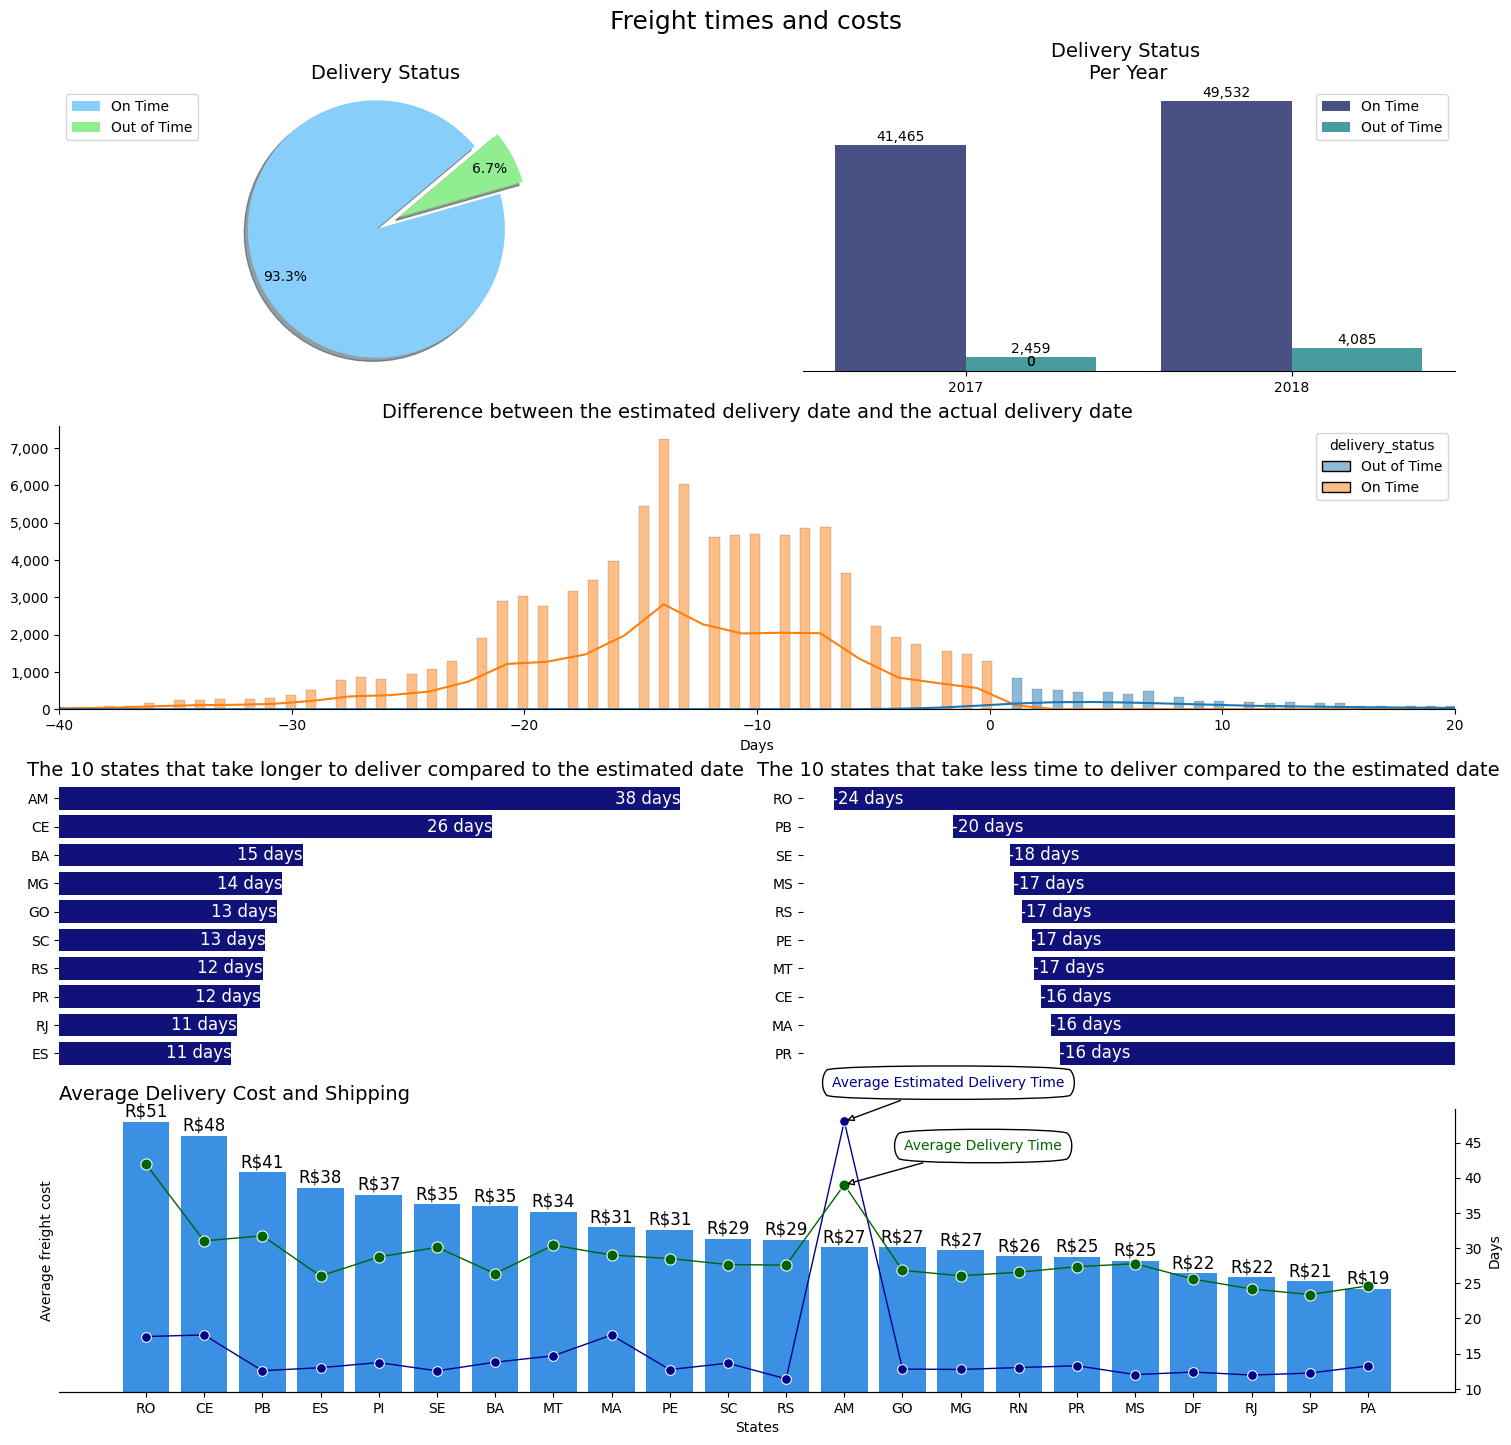

In [47]:
fig = plt.figure(constrained_layout=True, figsize=(15, 20))

# Axis definition
gs = GridSpec(6, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, :])

colors_list = ['lightskyblue', 'lightgreen']
explode = (0.0, 0.2)

ax1.pie(delivery_status["seller_id"], autopct='%1.1f%%',shadow=True, startangle=40,pctdistance=0.8, explode=explode, colors=colors_list)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=delivery_status["delivery_status"], loc='upper left')
ax1.set_title("Delivery Status", size=14, color='black')

sns.barplot(x="order_purchase_year", y="seller_id", data=delivery_status_year, ax=ax2, hue="delivery_status", palette="mako")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.legend(loc="best")
ax2.set_title("Delivery Status \nPer Year", size=14, color="black")
for p in ax2.patches:
        ax2.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticklabels([])
ax2.set_yticks([])


sns.histplot(data=freight_value, x=freight_value["delivery_day_time"], kde=True, ax=ax3, color=colors_list, hue=freight_value["delivery_status"])
ax3.set_xlim(-40,20)
ax3.set_xlabel("Days")
ax3.set_ylabel("")
ax3.set_title("Difference between the estimated delivery date and the actual delivery date", size=14, color="black")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

sns.barplot(x="delivery_day_time", y="seller_state",  data=delivery_low, ax=ax4, color="darkblue")
ax4.set_xlabel("Days")
ax4.set_ylabel("")
ax4.set_title("The 10 states that take longer to deliver compared to the estimated date",size=14, color="black")
for rect in ax4.patches:
    ax4.annotate('{:,.0f} days'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='right', size=12, color="white")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.axes.get_xaxis().set_visible(False)

sns.barplot(x="delivery_day_time", y="seller_state",  data=delivery_fast, ax=ax5, color="darkblue")
ax5.set_xlabel("Days")
ax5.set_ylabel("")
ax5.set_title("The 10 states that take less time to deliver compared to the estimated date",size=14, color="black")
for rect in ax5.patches:
    ax5.annotate('{:,.0f} days'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(-1, 0),textcoords='offset points', va='center', ha='left', size=12, color="white")
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.axes.get_xaxis().set_visible(False)

sns.barplot(x="seller_state", y="freight_value_x", data=delivery, ax=ax6, color="dodgerblue")
#ax6.legend(loc="best")
ax6.set_xlabel("States")
ax6.set_ylabel("Average freight cost")
ax6.set_title("Average Delivery Cost and Shipping", size=14, color="black", loc='left')
for p in ax6.patches:
        ax6.annotate('R${:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6_twx = ax6.twinx()
sns.lineplot(x="seller_state", y='customer_day_time', data=delivery, ax=ax6_twx, linewidth=1.0, color="darkblue", marker="o", markersize=7)
sns.lineplot(x="seller_state", y='purchase_estimated_day_time', data=delivery, ax=ax6_twx, linewidth=1.0, color="darkgreen", marker="o", markersize=8)
ax6_twx.set_ylabel("Days")
ax6_twx.spines['top'].set_visible(False)
ax6_twx.spines['left'].set_visible(False)

ax6_twx.annotate(f'Average Estimated Delivery Time', ("AM", 48), xytext=(75, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='darkblue', ha='center')

ax6_twx.annotate(f'Average Delivery Time', ("AM", 39), xytext=(100, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='darkgreen', ha='center')


plt.suptitle("Freight times and costs", size=18)

In [50]:
conditionlist = [
    (order_reviews["review_score"] <=2),(order_reviews["review_score"] == 3),(order_reviews["review_score"] >= 4)]

choicelist = ["Negative", "Neutral", "Positive"]
order_reviews["score_classification"] = np.select(conditionlist, choicelist, default='Not Specified')

conditionlist = [
    (order_reviews["review_comment_message"].isnull())]

choicelist = ["No Comment"]
order_reviews["comment_classification"] = np.select(conditionlist, choicelist, default="With Comments")

order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,score_classification,comment_classification
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59,Positive,No Comment
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13,Positive,No Comment
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24,Positive,No Comment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Positive,With Comments
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Positive,With Comments


In [51]:
#Filter what has information
comments = order_reviews[order_reviews.review_comment_message.notnull()]
comments = comments[["review_id", "review_comment_message"]]
comments.head()

,review_id,review_comment_message
3,e64fb393e7b32834bb789ff8bb30750e,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,Parabéns lojas lannister adorei comprar pela I...
9,8670d52e15e00043ae7de4c01cc2fe06,aparelho eficiente. no site a marca do aparelh...
12,4b49719c8a200003f700d3d986ea1a19,"Mas um pouco ,travando...pelo valor ta Boa."
15,3948b09f7c818e2d86c9a546758b2335,"Vendedor confiável, produto ok e entrega antes..."


In [52]:
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from nltk.corpus import stopwords
#import re

# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

review_comment_message = [' '.join(stopwords_removal(review)) for review in comments["review_comment_message"]]
comments["review_comment_message"] = review_comment_message

def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' ', r) for r in text_list]

# Applying RegEx
reviews_hiperlinks = re_hiperlinks(review_comment_message)
comments["review_comment_message"] = reviews_hiperlinks

def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' ', r) for r in text_list]

# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
comments["review_comment_message"] = reviews_dates

def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, '  ', r) for r in text_list]

# Applying RegEx
reviews_money = re_money(reviews_dates)
comments["review_comment_message"] = reviews_money

def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', '  ', r) for r in text_list]

# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
comments["review_comment_message"] = reviews_numbers

def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', '  ', r) for r in text_list]

# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
comments["review_comment_message"] = reviews_negation

def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
comments["review_comment_message"] = reviews_special_chars

def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
comments["review_comment_message"] = reviews_whitespaces

comments.head()

,review_id,review_comment_message
3,e64fb393e7b32834bb789ff8bb30750e,recebi bem antes prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,parabéns lojas lannister adorei comprar intern...
9,8670d52e15e00043ae7de4c01cc2fe06,aparelho eficiente site marca aparelho impress...
12,4b49719c8a200003f700d3d986ea1a19,pouco travando pelo valor ta boa
15,3948b09f7c818e2d86c9a546758b2335,vendedor confiável produto ok entrega antes prazo


In [53]:

wordcloud = WordCloud(width=5280, height=720, background_color='white', max_words=100).generate(str(reviews_whitespaces))
#plt.imshow(wordcloud)
#plt.axis('off')

Text(0.5, 0.98, 'Reviews')

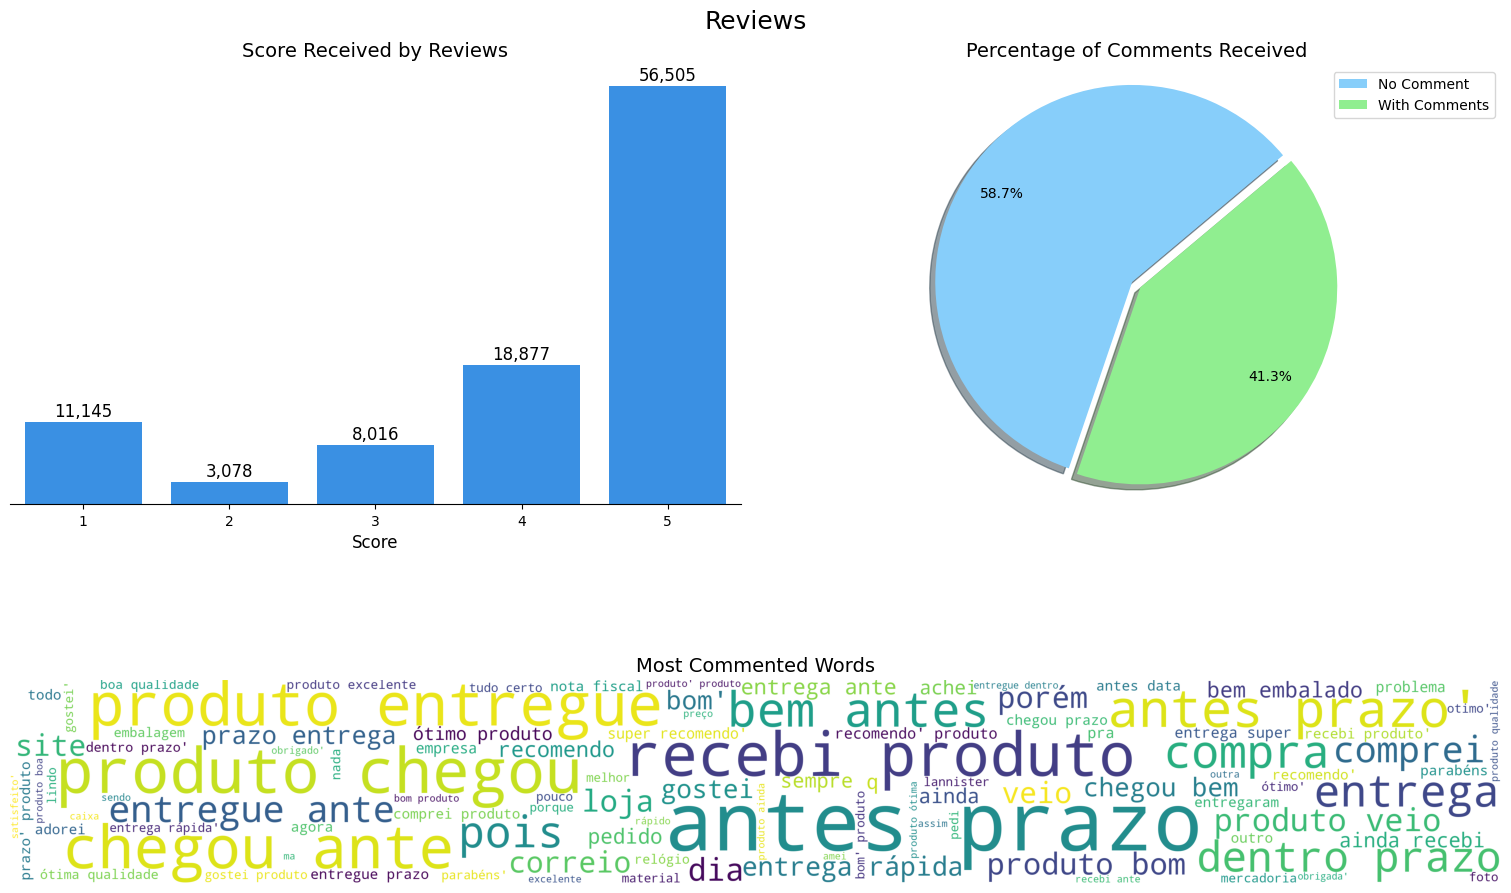

In [55]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, :])
#ax4 = fig.add_subplot(gs[2, 0])
#ax5 = fig.add_subplot(gs[2, 1])
#ax6 = fig.add_subplot(gs[3, :])

sns.barplot(x="review_score", y="review_id", data=order_reviews.groupby("review_score").count()["review_id"].reset_index(), ax=ax1, color="dodgerblue")
ax1.set_xlabel("Score", size=12)
ax1.set_ylabel("")
ax1.set_title("Score Received by Reviews", size=14, color="black")
for p in ax1.patches:
        ax1.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticklabels([])
ax1.set_yticks([])

comment_classification = order_reviews.groupby("comment_classification").count()["review_id"].reset_index()
colors_list = ['lightskyblue', 'lightgreen']
explode = (0.0, 0.05)

ax2.pie(comment_classification["review_id"], autopct='%1.1f%%',shadow=True, startangle=40,pctdistance=0.8, explode=explode, colors=colors_list)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(labels=comment_classification["comment_classification"], loc='upper right')
ax2.set_title("Percentage of Comments Received", size=14, color='black')

ax3.imshow(wordcloud)
ax3.axis('off')
ax3.set_title("Most Commented Words", size=14, color='black')

plt.suptitle("Reviews", size=18)

C:\Users\DELL\AppData\Local\Temp\ipykernel_19524\3500450980.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



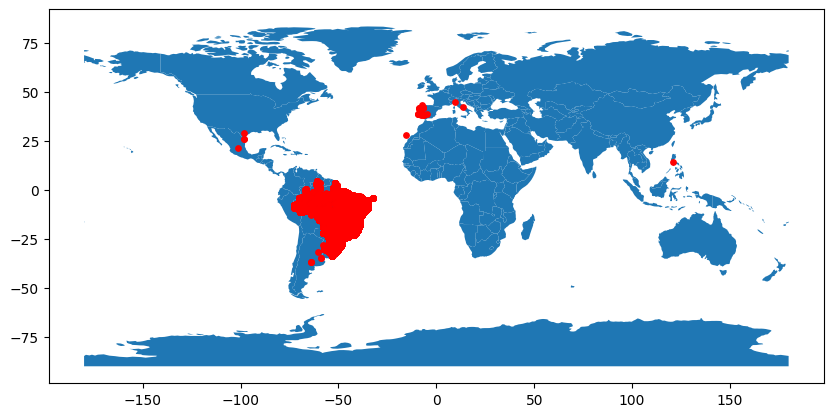

In [4]:
geometry = [Point(xy) for xy in zip(geolocation['geolocation_lng'], geolocation['geolocation_lat'])]
gdf = GeoDataFrame(geolocation, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plotG = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

##### 